# Using CoastSat for satellite-based coastline extraction of Deering, Alaska
Authors: Kristopher Carroll and Chaz Zunich

University of Alaska Anchorage

CSCE A490/A690 - Image Analysis using Google Earth Engine

Dr. Frank Witmer

<br>

The majority of this Jupyter notebook closely follows the example Jupyter notebook provided for the CoastSat library which can be found at:
- CoastSat:                                 https://github.com/kvos/CoastSat

<br>

## Initial settings

Grabbing the initial imports necessary to run data download, coastline extraction and image outputs

In [55]:
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

## Specifying Region of Interest (ROI)
Here we'll specify the bounding polygon of the target area (coastline around Deering, AK). We additionally specify the date range we're interested in and parameters for outputting downloaded images and analysis files.

In [56]:
# region of interest (longitude, latitude) - Deering, AK
polygon =  [[[-162.8235626220703, 66.05622435812153],
  [-162.674560546875, 66.05622435812153],
  [-162.674560546875, 66.10883816429516],
  [-162.8235626220703, 66.10883816429516],
  [-162.8235626220703, 66.05622435812153]]]
# converting polygon to smallest rectangle for analysis       
polygon = SDS_tools.smallest_rectangle(polygon)
# date range
dates = ['2016-08-01', '2016-09-30']
# specifying Landsat 8 and Sentinel-2 satellites
sat_list = ['S2','L8']
# name of the site
sitename = 'DEERING'
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'data')
# put all the inputs into a dictionary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath}

# before downloading the images, check how many images are available for your inputs
# SDS_download.check_images_available(inputs)

# download the images and store the metadata
# metadata = SDS_download.retrieve_images(inputs)
# or get the metadata from previously downloaded images
metadata = SDS_download.get_metadata(inputs)

## 2. Shoreline extraction

Now we can use the CoastSat library to specify the conditions for shoreline extraction. Specifically, we can specify the threshold for cloud cover for an image to be included in extraction, the output SRS coordinate system, and adjust settings that influence which portions of a coastline are likely to be detected based on their topgraphical characteristics. 

There is an option to include a reference coastline with which extracted coastline contours can be comapred to, with contours being further than a specified threshold being removed from the extracted coastline areas. This is an area we will expand upon in the future, providing reference coastlines such as the USGS coastline from an external file instead of having to create one manually.

We also save the preprocessed satellite images as JPGs for manual visual review to confirm our settings are having the desired effect on output.

In [57]:
settings = { 
    # general parameters:
    'cloud_thresh': 0.05,        # threshold on maximum cloud cover
    'output_epsg': 3857,        # epsg code of spatial reference system desired for the output   
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': True,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 2000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 50,         # radius (in metres) for buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 3000,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    # add the inputs defined previously
    'inputs': inputs
}
# save preprocessed images that meet settings as JPG files
SDS_preprocess.save_jpg(metadata, settings)

Satellite images saved as .jpg in c:\Users\kjcro\git\CoastSat\data\DEERING\jpg_files\preprocessed


## Batch shoreline detection
Now we'll use the CoastSat library to detect shorelines across images that met the above criteria. This process will use the CoastSat analysis tools that include classification of the images, generating a water probability map, and finding the coastline contours based on classification and other thresholded information in each image. We can also remove duplicates coastlines (from multiple images taken on the same day) and can remove images that have georeferencing errors greater than a threshold (10 meter displacement). CoastSat currently does not support the option to coregister images to preserve any images that demonstrate georeferencing errors so it's best to remove them from the analysis.

Coastline extraction occurs in two steps:
- Per-pixel classification into one of four classes using a neural network trained on 5000 reference pixels for each class. This classifies each pixel as either water, whitewater, sand or other land features and is used to determine the area of interest for coastline extraction at specific class boundaries (water-sand and water-other land).
- Coastline contour generation through the use of a marching squares algorithm to determine the iso-valued contour of Modified Normalized Difference Water Index (MNDWI) values within the buffered area. 

We'll also output the resulting coastlines as a GeoJSON file which can be used in GIS software or as an asset back in Google Earth Engine.

In [58]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

# saving GeoJSON for coastlines
geomtype = 'lines' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
gdf.crs = {'init':'epsg:'+str(settings['output_epsg'])} # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

Mapping shorelines:
L8:   100%
S2:   80%

StopIteration: User cancelled checking shoreline detection

Simple plot of the mapped shorelines. The coordinates are stored in the output dictionary together with the exact dates in UTC time, the georeferencing accuracy and the cloud cover. These coastlines are all fairly close to each other as the date range specified is fairly limited (2 months), but this indicates that more precision might be gained from combining the images in smaller date ranges as a composite image to determine a more accurate coastline that is more resilient to noise caused by tidal interactions, imagery variation, and atmospheric effects or cloudiness.

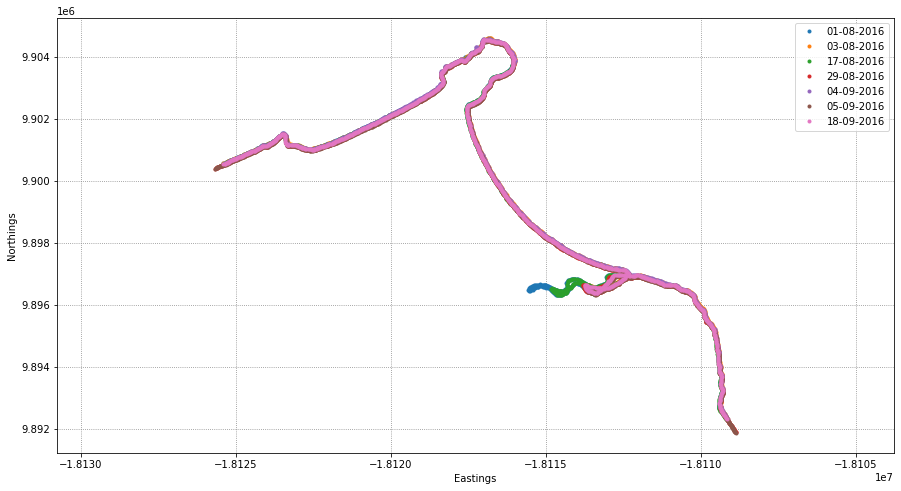

In [34]:
%matplotlib inline
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
plt.legend()

## 3. Shoreline analysis

Transect analysis can be found at the following link to Google Earth Engine's JavaScript code editor:

https://code.earthengine.google.com/e3d1a1ee4af53921d1a661f6dff88767